In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import math
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.optim as optim

import scipy.io
import pandas as pd
from scipy.io import loadmat
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

from Networks import *
from Networks.VarProjNetwork import *
from Networks.Trajectory import *
from Data.data_processing import *
from Networks.Trajectory_time import *
from Model.model import *


Modify n_steps and step_size for testing 


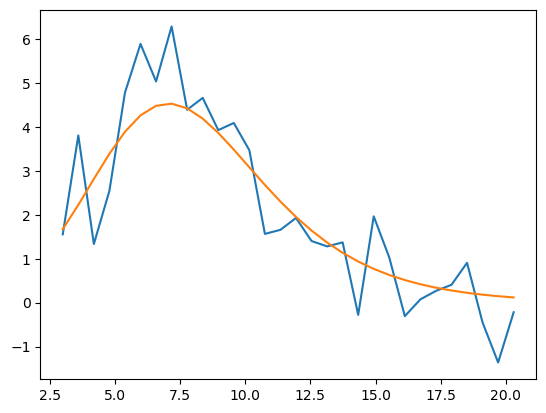

In [2]:
n_steps = 30
step_size = 0.7

# Generate time steps
t = np.linspace(3, (n_steps - 1) * step_size, n_steps) #(n_steps,)

a1 = 1.2
a2 = -0.2
r = 1.3
ny = 2.1


#applying the function and create sample training data
def x_estimate(t,a1,a2,r,ny):
  u = (a1*ny**(1-r) + a2) * np.exp(a1 * (1-r) * t)
  v = ((ny ** (1-r) + a2/a1) * np.exp( a1 * (1-r) * t) - a2/a1)**(r/(1-r))
  return u*v

noise_level = 0.8 # Adjust this value to control the noise magnitude

# / 10.0 for easier training
x_esti = x_estimate(t, a1, a2, r, ny) / 10.0

# Create Gaussian noise
# The shape of the noise should match x_esti
random_noise = noise_level * np.random.randn(*x_esti.shape)

# Add noise to the estimated values
x_target = x_esti + random_noise


plt.plot(t, x_target, label='Data After Add Noise')
plt.plot(t, x_esti, label ='Original Data Without Noise')

In [3]:
params_init = torch.tensor([1.2, 4.2])
t = torch.from_numpy(t).float()
model = FCVPNN_time(t, params_init=params_init)

total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 3941


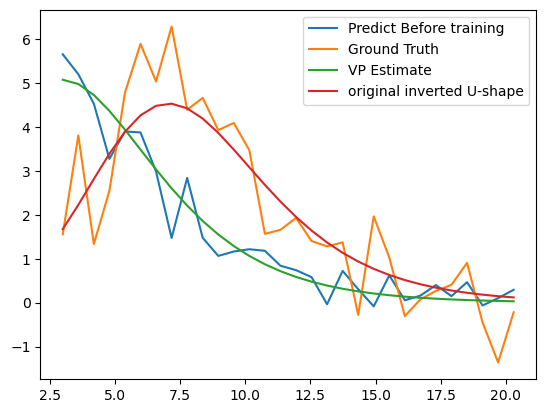

In [4]:
x_input = x_target #df['Vehicles'][5+24*2002:5+24 + 24*2002]/10.0

inputs = torch.tensor(x_input).view(1,1, n_steps).float()
labels =torch.tensor(x_target).view(1,1, n_steps).float()

out_2 , vpp = model(inputs)
out_2 = out_2.view(n_steps ).detach().numpy()
vpp = vpp.view(n_steps ).detach().numpy()
plt.plot(t,out_2, label='Predict Before training')
plt.plot(t,x_target, label='Ground Truth')
plt.plot(t,vpp, label='VP Estimate')
plt.plot(t,x_esti, label='original inverted U-shape')
plt.legend()

In [5]:
criterion = VPLoss(nn.MSELoss(), 0.5)
optimizer = optim.Adagrad(model.parameters(),
                       lr=0.03,
                       lr_decay=0.00001,
                       weight_decay=0.00001)

for i in range(1000):
  optimizer.zero_grad()
  outputs = model(inputs)
  loss = criterion(outputs, labels)

  loss.backward()
  optimizer.step()

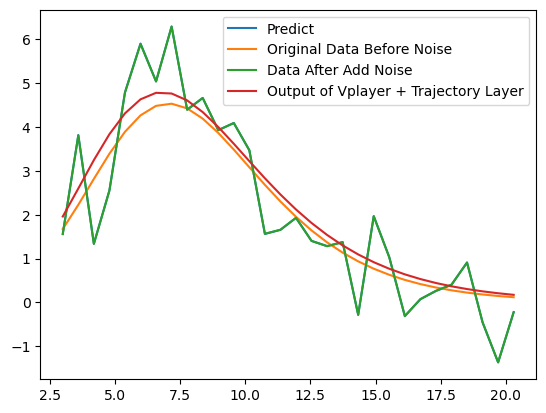

In [6]:
out_2, vpp= model(inputs)
out_2 = out_2.view(n_steps ).detach().numpy()
vpp = vpp.view(n_steps ).detach().numpy()
plt.plot(t,out_2, label='Predict')
plt.plot(t,x_esti, label='Original Data Before Noise')
plt.plot(t, x_target, label='Data After Add Noise')
plt.plot(t, vpp, label='Output of Vplayer + Trajectory Layer')
plt.legend()


In [7]:
# for name, param in model.traj.named_parameters():
#     if param.requires_grad:  # Check if the parameter is trainable
#         print(f"Parameter Name: {name}")
#         print(f"Parameter Value: {param.data}")  # Print the actual parameter values

In [8]:
# params = []
# for name, param in model.vp.named_parameters():
#     if param.requires_grad:  # Check if the parameter is trainable
#         print(f"Parameter Name: {name}")
#         print(f"Parameter Value: {param.data}")  # Print the actual parameter values
#         params.append(param.data)